# Desmistificando la transformada de ondeletas

<a href="https://juanfonsecasolis.github.io/">Juan M. Fonseca-Solís</a> · Febrero 2021 · lecturad de 7 min

---

## Resumen

En este ipython notebook estudiamos la transformada de ondeletas (o _wavelets_ como se conoce en inglés). La misma es un tema interesante de estudiar porque constituye una alternativa a la transformada de Fourier de corto plazo (STFT, por sus siglas en Inglés) al atenuar el problema del principio de incertidumbre de Heinserberg, que dicta que a mayor resolución frecuencial menor resolución temporal, y viceversa. En la literatura es posible encontrar la transformada de ondeletas continua (CWT, por sus siglas en Inglés), su versión discreta o _discrete time wavelet transform_ (DTWT), y el banco de filtros que la define, asociado a un fenómeno llamado distribución diádica. Además, es posible encontrar librerías que implementan la DTWT para el análisis de frecuencias. Aunque este notebook no tiene componentes originales, explicamos la teoría básica de los wavelets y varios ejemplos de librerías académicas disponibles gratuitamente.

# Definición de ondeleta

Una ondeleta $\psi(t)$ se define como una señal de energía finita y corta duración, que debe cumplir dos condiciones: tener media cero y tener energía finita (principio de admisibilidad). La primer condición puede expresarse como sigue [2]:

$$
\int_{-\infty}^{\infty}{\psi(t)dt} = 0,
$$

y la segunda, requiere calcular la transformada de Fourier de la ondeleta, o $\Psi(\omega)=\mathscr{F}\{\psi(t)\}(f)$, para integrar sobre un cociente de la forma:

$$
C_{\psi} = \int_{-\infty}^{\infty}{\frac{|\Psi(\omega)|^2}{|\omega|}d\omega} < \infty,
$$

donde $t \in \mathbb{R}$ representa el tiempo continuo, $\omega=2\pi f$ es la frecuencia expresada en radianes por segundoy $f \in \mathbb{R}$ es la frecuencia en hercios. Un ejemplo de una ondeleta es la función Morlet, que se define como sigue [1]:

$$
\psi(t) = \cos(5t) e^{\frac{-t^2}{2}}.
$$

Populating the interactive namespace from numpy and matplotlib


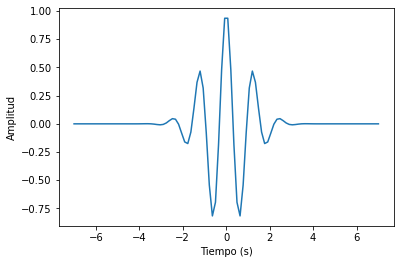

In [2]:
%pylab inline
from scipy import signal
import numpy as np

def morlet(x):
    return np.exp((-x**2)/2) * np.cos(5*x)

t = np.linspace(-7,7,100)
plt.plot(t,morlet(t))
# plt.plot(t,sombrero(t))
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.show()

A partir de una función como esta (llamada _ondeleta madre_) se pueden derivar otras ondeletas de la misma forma pero que sufren una serie de escalamientos y desplazamientos definidos según los parámetros $a$ y $b$, respectivamente:

$$
\psi_{a,b}(t) = \frac{1}{\sqrt{a}}\,\psi\left(\frac{t-b}{a}\right).
$$

Por ejemplo, al realizar un escalamiento por $0.5$s y un desplazamiento por $4$s sobre la ondeleta madre morlet obtenemos la siguiente curva:

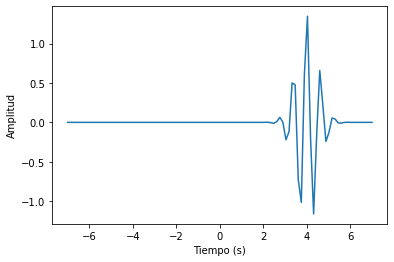

In [3]:
def ondeletaMadre(t,a,b,ondeletaFunc):
    return ondeletaFunc((t-b)/a) * 1.0/np.sqrt(a)

plt.plot(t,ondeletaMadre(t,a=0.5,b=4,ondeletaFunc=morlet)) # retrasar 2 segundos y cambiar ancho a la mitad
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.show()

Es una práctica recomendada escoger una ondeleta que siga la misma forma de la señal que queremos analizar, y como más adelante vamos a analizar un tono puro implementado con un senoidal, la ondeleta Morlet es una buena elección. Otras ondeletas conocidas son la ondeleta sombrero (Ricker) o la ondeleta Haar. Como dato curioso la ondeleta Haar, propuesta en 1909 por el matemático húngaro Alfréd Haar, es definida por una función cuyo soporte es $-1$ en el rango $[0,0.5]$, $1$ en el rango $[0.5,1]$ y cero en el resto; y es usada para detectar bordes en imágenes por su buena resolución temporal [5,6].

# Transformada continua de ondeleta

La ondeleta madre permite definir otro concepto llamado _transformada de ondeleta continua_ (CWT, por sus siglas en inglés) que permite obtener coeficientes de análisis con esta ecuación [2]:

$$
\text{CWT}_f(a,b) = \int_{-\infty}^{\infty}{x(t)\,\psi^{*}_{a,b}(t)dt},  
$$

donde el operador $\cdot^{*}$ representa el conjugado complejo (definido como $(a+bi)^{*}=a-bi$, para recordar). Al igual que pasa con la transformada de Fourier, esta ecuación es también una correlación entre la función ondeleta (escalada y trasladada por $a$ y $b$) y la función analizada $x$. Abajo vemos un ejemplo de un escalograma definido por la CWT:

Duracion: 0.050 s


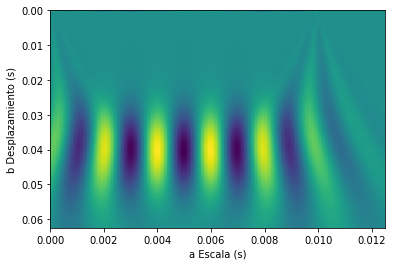

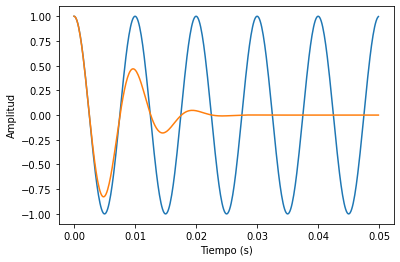

In [13]:
def CWT(f,a,b,ondeleta=morlet):    
    return np.dot(ondeletaMadre(np.arange(0,len(f)),a,b,ondeleta), f)

F0 = 100 # frec. fundamental (Hz) or 0.001s of period
Fs = 8e3 # frec. muestreo (Hz)
N = int(5*Fs/F0) # mostrar 6 periodos de la senal
T = N/Fs

print('Duracion: %.3f s' % (N/Fs))

n = np.arange(0,N)
y1 = np.cos(2*np.pi*F0/Fs*n) # f=F0/Fs: frecuencia discreta

A = np.linspace(1,100,100)
B = np.linspace(1,500,100)
F = np.zeros([len(A),len(B)])
for iA in range(0,len(A)):
    for iB in range(0,len(B)):
        F[iA,iB]=CWT(y1,A[iA],B[iB])
       
figure()
plt.imshow(F, aspect='auto', extent=[0, A[-1]/Fs, B[-1]/Fs,0]) 
plt.xlabel('a Escala (s)')
plt.ylabel('b Desplazamiento (s)')
show()

figure()
t=n/Fs
plt.plot(t,y1)
w = ondeletaMadre(t,a=0.008,b=0,ondeletaFunc=morlet)
plt.plot(t,w/max(abs(w)))
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
show()

Al observar el escalograma es posible ubicar un pico de energía en $0.008$s, y con este periodo precisamente es posible obtener la mejor correspondencia con la señal analizada.

# Transformada discreta de ondeletas

La transformada de ondeletas, al igual que la transformada de Fourier, tiene una versión discreta definida como sigue [3,4]:

$$
\text{DTWT}_f[a,b] = \frac{1}{\sqrt{b}} \sum_{m=0}^{p-1}{x[t_m] \, \psi\big[{\frac{t_m-a}{b}}\big]},  
$$

donde:
* $t_m = t(mT_s)$,
* $T_s$ es el periodo de muestreo (en segundos),
* $a=K2^{-j}$,
* $b=2^{-j}$,
* $j \in \mathbb{N}$ es el índice de escalamiento,
* $K \in \mathbb{N}$ es el índice de la ondeleta.

Como $a$ y $b$ son potencias de dos, se dice que la transformada DTWT es diádica; esto además define un banco de filtros que se traslapan de la siguiente forma:

<img src="img/bancoFiltros.jpg" width="40%"></img>

(1.000000,1.000000)
(0.500000,0.500000)
(0.250000,0.250000)
(0.125000,0.125000)
(0.062500,0.062500)


<Figure size 432x288 with 0 Axes>

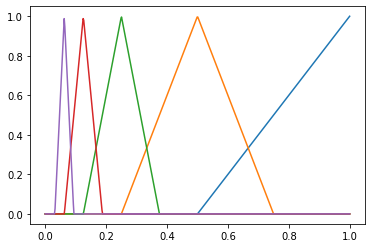

(2.000000,1.000000)
(1.000000,0.500000)
(0.500000,0.250000)
(0.250000,0.125000)
(0.125000,0.062500)


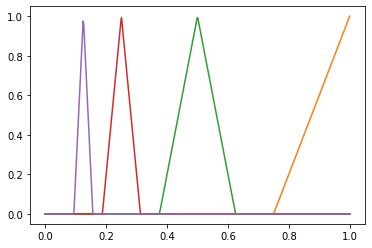

In [5]:
def triangulo(x):
    return 1-np.abs(2*x) if np.abs(x)<=0.5 else 0

plt.figure()
time = np.linspace(0,1,500)

for k in range(1,3):
    plt.figure()
    for j in range(0,5):
        b = 2**(-j)
        a = k*b
        print('(%2f,%2f)' % (a,b))
        plt.plot(time,[triangulo((t-a)/b) for t in time])
    plt.show() 

A nivel computacional, este análisis puede optimizarse usando una estructura como la siguiente [6]:

<img src="img/bancoFiltros2.png" width="60%"></img>

donde la señal es analizada por un filtro pasa-bajas L y pasa-altas H para definir los coeficientes de análisis cD1 y cA1, respectivamente; luego los coeficientes son procesados por filtros inversos H' y L' para reconstruir la señal [6]. Este análisis por el banco de filtros está relacionado con la [propiedad de multiresolución](https://en.wikipedia.org/wiki/Multiresolution_analysis), que constituye el atractivo principal de la transformada de ondeletas, pues aplicando una ventana de análisis más larga para frecuencia bajas y más corta para frecuencias altas logra atenuar el problema del principio de Incertidumbre de Heisenberg. Este principio afecta a la STFT pues en ella las ventanas de análisis son fijas, y por lo tanto a mayor resolución temporal se obtiene menor resolución frecuencial y viceversa [6]. En la figura de arriba, usamos una DWT de nivel-1, que es la más sencilla, pero usando niveles más altos es posible obtener coeficientes más detallados.

<img src="img/multiresolution.jpg" width="50%"></img>

# Librerias existentes

La CWT y la DTWT pueden encontrarse implementadas en Python para las librerías Scipy (`signal.CWT`) y Obspy (`obspy.signal.tf_misfit.CWT`). Abajo se proponen dos ejemplos para calcular los escalogramas del tono puro que usamos anteriormente. La librería Signal.CWT arroja resultados similares a nuestra implementación, donde es necesario interpretar la escala y el desplazamiento para encontrar la frecuencia del tono construido.

(63, 400)


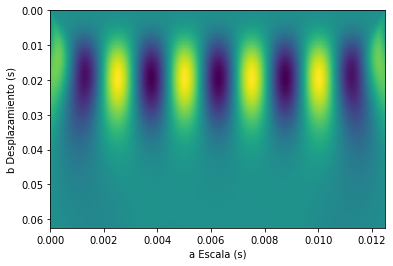

Tiempo transcurrido: 0.20s


In [57]:
from IPython.display import Audio
import time

def signalCWT(y,Fs,xRange=None,yRange=None):
    widths = np.arange(1, 64)
    cwtmatr = signal.cwt(y, wavelet=signal.ricker, widths=widths)

    print(cwtmatr.shape)
    plt.imshow(cwtmatr, extent=[0, A[-1]/Fs, B[-1]/Fs,0], aspect='auto', # [-1, 1, 1, 63]
               vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
    plt.xlabel('a Escala (s)')
    plt.ylabel('b Desplazamiento (s)')
    if xRange != None:
        plt.xlim(xRange)
    if yRange != None:
        plt.ylim(yRange)
    plt.show()

def benchmark(function, y, Fs, xRange=None, yRange=None):
    start = time.time()
    function(y, Fs, xRange, yRange)
    print('Tiempo transcurrido: %.2fs' % (time.time() - start))
    
benchmark(signalCWT, y1, Fs)

Por otra parte, obspy.signal ofrece una interpretación más sencilla porque ya expresa el eje de la escala en términos de la pseudofrecuencia, y además, el tiempo de procesamiento es similar. Cabe mencionar que no analizamos más señales para obtener mejores estimados del tiempo porque ese no es el propósito de este notebook. 

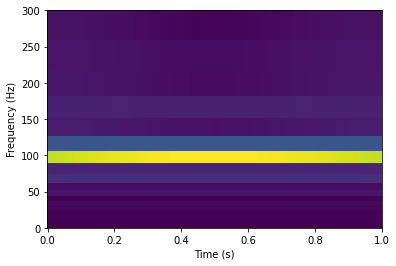

Tiempo transcurrido: 0.14s


In [58]:
import obspy # pip3 install obspy
from obspy.imaging.cm import obspy_sequential
from obspy.signal.tf_misfit import cwt

def obspyCWT(y,Fs,xRange=None, yRange=None):
    scalogram = cwt(st=y, dt=1.0/Fs, w0=32, fmin=0.0001, fmax=Fs/2) # morlet
    ax = plt.figure(2).add_subplot(111)
    t = np.linspace(0,T,len(y))
    x_axis, y_axis = np.meshgrid(t,np.logspace(np.log10(0.0001), np.log10(Fs/2), scalogram.shape[0]))
    ax.pcolormesh(x_axis, y_axis, np.abs(scalogram), cmap=obspy_sequential, shading='auto')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    if xRange != None:
        plt.xlim(xRange)
    if yRange != None:
        plt.ylim(yRange)
    plt.show()
    
benchmark(obspyCWT, y1, Fs, None, [0,3*F0])

# Transformada wavelet vs. STFT

Ahora analizamos un barrido lineal en frecuencia en el rango de los 20 a 20000 kHz para comparar si la transformada de ondeletas ofrece a simple vista una mejor resolución temporal-frecuencial:

In [80]:
# construimos un barrido de frecuencias
rango = [20, 20e3] # el rango promedio de audicion humano en Hz
Fs = 44.1 * 1e3 # la tasa de muestreo de los equipos comerciales
T = 1.0 # segundos (t1-t0)
N = int(T*Fs) # s . 1/s
n = np.arange(0,N)
F0 = (rango[1]-rango[0])*n/N + rango[0]
y2 = np.sin(2*np.pi*F0/(2*Fs)*n) # f=F0/Fs: frecuencia discreta
Audio(y2, rate=Fs)

Utilizamos la implementación obspy.signal de la transformada de ondeletas para analizar la señal:

<Figure size 432x288 with 0 Axes>

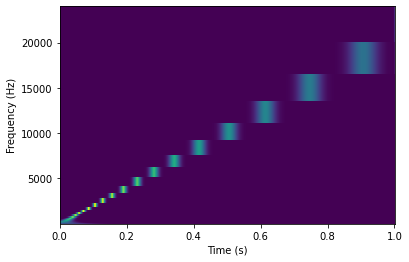

Tiempo transcurrido: 4.46s


<Figure size 432x288 with 0 Axes>

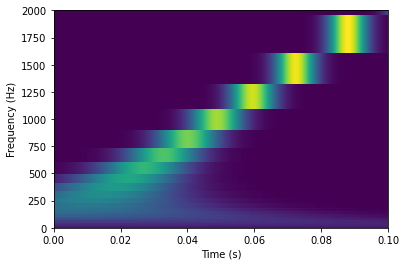

Tiempo transcurrido: 4.14s


In [82]:
def benchmark2(function, y, Fs, xRange=None, yRange=None):
    figure()
    benchmark(function, y, Fs)
    figure()
    benchmark(function, y, Fs, xRange, yRange)

benchmark2(obspyCWT, y2, Fs, [0, 0.1], [0,2e3])

Se observa que las frecuencias bajas tienen una resolución más alta que las frecuencias altas, y, al hacer un acercamiento, la resolución de las frecuencias bajas es buena. Ahora aplicamos la STFT:

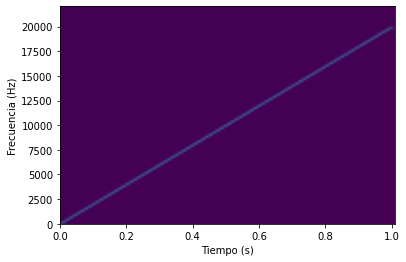

Tiempo transcurrido: 0.28s


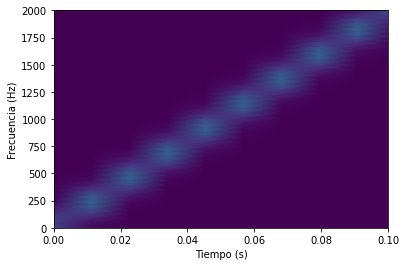

Tiempo transcurrido: 0.17s


In [79]:
def STFT(y,Fs,xRange=None, yRange=None):
    '''
    Tomada de https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html
    '''
    f, t, Zxx = signal.stft(y, Fs, nperseg=1000)
    plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=max(y2), shading='gouraud')
    plt.ylabel('Frecuencia (Hz)')
    plt.xlabel('Tiempo (s)')
    if xRange != None:
        plt.xlim(xRange)
    if yRange != None:
        plt.ylim(yRange)
    plt.show()

benchmark2(STFT, y2, Fs, [0, 0.1], [0,2e3])

Se observa que todas las frecuencias tienen la misma resolución, y, al hacer un acercamiento, la resolución de las frecuencias bajas es mala y borrosa, confirmando la idea de que la transformada de ondeletas funciona como una "lupa" dándole a cada frecuencia la resolución necesaria.

# Conclusiones
Una ondeleta es una función de corta duración que cumple dos condiciones: tener media cero y cumplir el principio de admisibilidad (tener energía finita a lo largo del tiempo). Tres ejemplos de ondeletas son la función Morlet, Ricker (o sombrero mexicano) y la ondeleta de Haar. Una ondeleta madre sufre una seria de escalamientos y desplazamiento para definir la transformada continua (CWT) y la transformada discreta (DTWT), ambas son correlaciones de la función de entrada con un banco de filtros. Esta correlación da lugar a un concepto llamado escalograma, que a diferencia del espectrograma, cumple con el principio de multiresolución, que permite mitigar el principio de incertidumbre de Heisenberg. En el caso de la DTWT, el banco de filtros sigue una distribución diádica (en potencias de dos), y a nivel computacional los filtros están dispuestos en forma de cascada (la porción de la señal filtrada por el filtro pasabajas es descompuesta recursivamente). Python ofrece dos formas de calcular la CWT a través de las librerías `signal.CWT` y `obspy.signal.tf_misfit.CWT`, ambas presentan tiempo similares de procesamiento con la única señal empleada.

# Referencias

1. Wikipedia contributors. (2021, February 17). Mexican hat wavelet. In Wikipedia, The Free Encyclopedia. Retrieved 00:05, March 7, 2021, from https://en.wikipedia.org/w/index.php?title=Mexican_hat_wavelet&oldid=1007284050

2. M. Vetterli, J. Kovacevic. Wavelets and Subband Coding. Orignally published in 1995 by Prentice Hall PTR, Englewood Cliffs, New Jersey. Reissued by authors in 2007.

3. Wikipedia contributors. (2021, March 3). Correlation and dependence. In Wikipedia, The Free Encyclopedia. Retrieved 00:47, March 7, 2021, from https://en.wikipedia.org/w/index.php?title=Correlation_and_dependence&oldid=1010073167

4. Andrew Nicoll. The Wavelet Transform for Beginners. URL: https://youtu.be/kuuUaqAjeoA (consultado por última vez el 05/22/21)

5. Wikipedia contributors. (2021, March 25). Haar wavelet. In Wikipedia, The Free Encyclopedia. Retrieved 03:43, May 27, 2021, from https://en.wikipedia.org/w/index.php?title=Haar_wavelet&oldid=1014128738\

6. D. Lee Fugal. Conceptual Wavelets, in digital signal processing. Space and signals technical publishing. 2009. ISBN 978-0-9821994-5-9.

---
<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="Licencia de Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/88x31.png" /></a><br/>Este obra está bajo una <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">licencia de Creative Commons Reconocimiento-NoComercial-SinObraDerivada 4.0 Internacional</a>. El sitio [juanfonsecasolis.github.io](https://juanfonsecasolis.github.io) es un blog dedicado a la investigación independiente en temas relacionados al procesamiento digital de señales. Para reutilizar este artículo y citar las fuente por favor utilice el siguiente Bibtex:

```
@online{Fonseca2021,
  author = {Juan M. Fonseca-Solís},
  title = {Desmistificando la transformada de ondeletas},
  year = 2021,
  url = {https://juanfonsecasolis.github.io/blog/JFonseca.wavelets.html},
  urldate = {}
}
```